# Radiative-Convective Equilibrium with CAM3 scheme

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

#  Here is how to set a simple RCE in `climlab`

By initializing each component with the same state object, the components are already effectively coupled. They all act to modify the same state object.

No extra coupling code is necessary.

In [2]:
# initial state (temperatures)
state = climlab.column_state(num_lev=20, num_lat=1, water_depth=5.)

In [3]:
#  Create a parent process
rce = climlab.TimeDependentProcess(state=state)
## Create individual physical process models:
#  fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Hard convective adjustment
convadj = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
# CAM3 radiation with default parameters and interactive water vapor
rad = climlab.radiation.CAM3(state=state)
rad.q = h2o.q

# Couple the models
rce.add_subprocess('Radiation', rad)
rce.add_subprocess('ConvectiveAdjustment', convadj)
rce.add_subprocess('H2O', h2o)

#  Make diagnostic water vapor field easy to access
rce.q = rce.subprocess.H2O.q

In [4]:
print rce

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (20,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   ConvectiveAdjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   Radiation: <class 'climlab.radiation.cam3.CAM3'>



In [5]:
rce.state

{'Tatm': Field([ 200.        ,  204.10526316,  208.21052632,  212.31578947,
         216.42105263,  220.52631579,  224.63157895,  228.73684211,
         232.84210526,  236.94736842,  241.05263158,  245.15789474,
         249.26315789,  253.36842105,  257.47368421,  261.57894737,
         265.68421053,  269.78947368,  273.89473684,  278.        ]),
 'Ts': Field([ 288.])}

In [6]:
rce.integrate_years(5)

Integrating for 1826 steps, 1826.211 days, or 5 years.
Total elapsed time is 4.99942230115 years.


In [7]:
rce.state

{'Tatm': Field([ 149.60214563,  184.40014626,  203.23184288,  216.6747333 ,
         227.29228779,  236.14260969,  243.77260381,  250.50430522,
         256.5444144 ,  262.03403484,  267.07406061,  271.73929388,
         276.08682874,  280.16129672,  283.9982912 ,  287.6266833 ,
         291.07023553,  294.34875527,  297.4789377 ,  300.4749939 ]),
 'Ts': Field([ 301.92660593])}

In [8]:
rce.q

Field([  5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
         1.27398211e-05,   4.51006511e-05,   1.16692340e-04,
         2.48148808e-04,   4.61837851e-04,   7.80895725e-04,
         1.22855642e-03,   1.82769908e-03,   2.60055103e-03,
         3.56849985e-03,   4.75198161e-03,   6.17042172e-03,
         7.84221218e-03,   9.78471355e-03,   1.20142737e-02,
         1.45462574e-02,   1.73950833e-02])

In [9]:
rce.subprocess.Radiation.input

{'CFC11': 1e-09,
 'CFC12': 1e-09,
 'CH4': 1e-09,
 'CO2': 380.0,
 'N2O': 1e-09,
 'O3': Field([  1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09]),
 'aldif': Field([ 0.07]),
 'aldir': Field([ 0.07]),
 'asdif': Field([ 0.07]),
 'asdir': Field([ 0.07]),
 'ciwp': Field([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'cldf': Field([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'clwp': Field([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'cosZen': Fiel

# Latitudinally, seasonally varying RCE

In [10]:
# initial state (temperatures)
state2 = climlab.column_state(num_lev=20, num_lat=30, water_depth=10.)

In [11]:
#  Create a parent process
rcelat = climlab.TimeDependentProcess(state=state2)
## Create individual physical process models:
#  seasonal insolation
insol = climlab.radiation.DailyInsolation(domains=rcelat.Ts.domain)
#  fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state2)
#  Hard convective adjustment
convadj = climlab.convection.ConvectiveAdjustment(state=state2, adj_lapse_rate=6.5)
# CAM3 radiation with default parameters and interactive water vapor
rad = climlab.radiation.CAM3(state=state2)
#  Couple the insolation and water vapor to radiation process
rad.q = h2o.q
rad.insolation = insol.insolation

# Add all subprocesses to the parent process
rcelat.add_subprocess('Insolation', insol)
rcelat.add_subprocess('Radiation', rad)
rcelat.add_subprocess('ConvectiveAdjustment', convadj)
rcelat.add_subprocess('H2O', h2o)

#  Make diagnostic water vapor field easy to access
rcelat.q = rcelat.subprocess.H2O.q

In [12]:
rcelat.integrate_years(5)

Integrating for 1826 steps, 1826.211 days, or 5 years.
Total elapsed time is 4.99942230115 years.


In [13]:
rcelat.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 5.99875917953 years.


In [14]:
def plot_temp_section(model, timeave=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if timeave:
        field = model.timeave['Tatm'].transpose()
    else:
        field = model.Tatm.transpose()
    cax = ax.contourf(model.lat, model.lev, field)
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    fig.colorbar(cax)

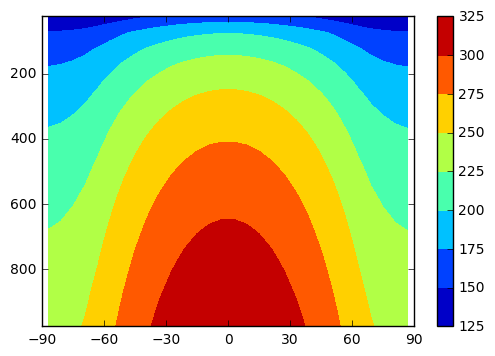

In [15]:
plot_temp_section(rcelat)

# Same thing, but also including meridional temperature diffusion

In [16]:
#  Create and exact clone of the previous model
diffmodel = climlab.process_like(rcelat)

In [17]:
# thermal diffusivity in W/m**2/degC
D = 0.05
# meridional diffusivity in 1/s
K = D / diffmodel.Tatm.domain.heat_capacity[0]
print K

9.7609561753e-08


In [18]:
d = climlab.dynamics.MeridionalDiffusion(K=K, state={'Tatm': diffmodel.state['Tatm']}, **diffmodel.param)

In [19]:
diffmodel.add_subprocess('diffusion', d)

In [20]:
diffmodel.integrate_years(5)

Integrating for 1826 steps, 1826.211 days, or 5 years.
Total elapsed time is 10.9981814807 years.


In [21]:
diffmodel.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 11.9975183591 years.


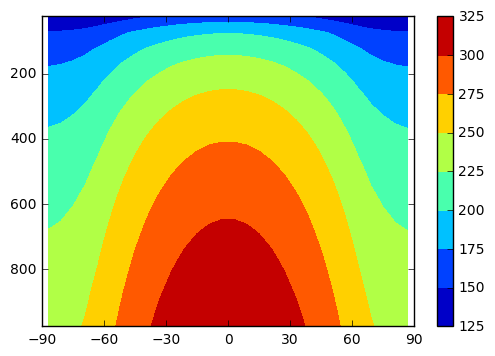

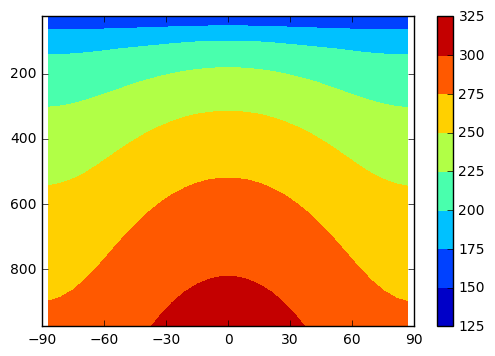

In [22]:
plot_temp_section(rcelat)
plot_temp_section(diffmodel)

In [23]:
def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate
    from climlab import constants as const
    lat_rad = np.deg2rad( lat_deg )
    return ( 1E-15 * 2 * np.math.pi * const.a**2 * integrate.cumtrapz( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )


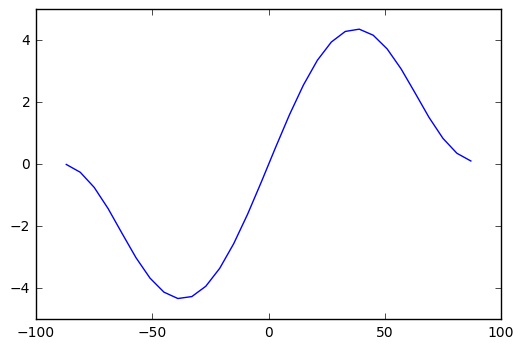

In [24]:
#  Plot the northward heat transport in this model
Rtoa = np.squeeze(diffmodel.timeave['ASR'] - diffmodel.timeave['OLR'])
plt.plot(diffmodel.lat, inferred_heat_transport(Rtoa, diffmodel.lat))

# If you want explicit surface fluxes...

All the models above use a convective adjustment that simultaneously adjustments `Tatm` and `Ts` to the prescribed lapse rate.

We can instead limit the convective adjustment to just the atmosphere. To do this, we just have to change the `state` variable dictionary in the convective adjustment process.

Then we can invoke process models for **sensible and latent heat fluxes** that use simple bulk formulae. Tunable parameters for these include drag coefficient and surface wind speed.

In [25]:
diffmodel2 = climlab.process_like(diffmodel)

#  Hard convective adjustment -- ATMOSPHERE ONLY
convadj2 = climlab.convection.ConvectiveAdjustment(state={'Tatm':diffmodel2.state['Tatm']}, adj_lapse_rate=6.5)
diffmodel2.add_subprocess('ConvectiveAdjustment', convadj2)

print diffmodel2

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (30, 20) 
  Ts: (30, 1) 
The subprocess tree: 
top: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   ConvectiveAdjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   Radiation: <class 'climlab.radiation.cam3.CAM3'>
   Insolation: <class 'climlab.radiation.insolation.DailyInsolation'>



In [26]:
#  Now add surface flux processes
#  Add surface heat fluxes

shf = climlab.surface.SensibleHeatFlux(state=diffmodel2.state, Cd=0.5E-3)
lhf = climlab.surface.LatentHeatFlux(state=diffmodel2.state, Cd=0.5E-3)
#  set the water vapor input field for LHF process
lhf.q = diffmodel2.subprocess['H2O'].q
diffmodel2.add_subprocess('SHF', shf)
diffmodel2.add_subprocess('LHF', lhf)

print diffmodel2

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (30, 20) 
  Ts: (30, 1) 
The subprocess tree: 
top: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   ConvectiveAdjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>
   Radiation: <class 'climlab.radiation.cam3.CAM3'>
   Insolation: <class 'climlab.radiation.insolation.DailyInsolation'>



In [27]:
diffmodel2.integrate_years(5)

Integrating for 1826 steps, 1826.211 days, or 5 years.
Total elapsed time is 16.9969406602 years.


In [28]:
diffmodel2.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 17.9962775386 years.


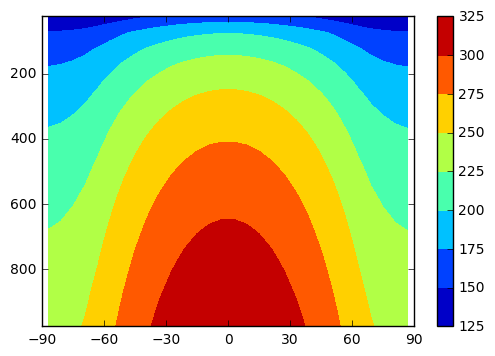

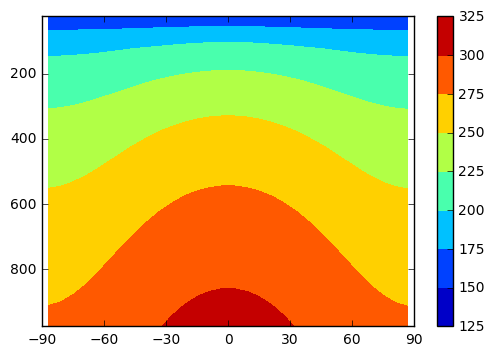

In [29]:
plot_temp_section(rcelat)
plot_temp_section(diffmodel2)

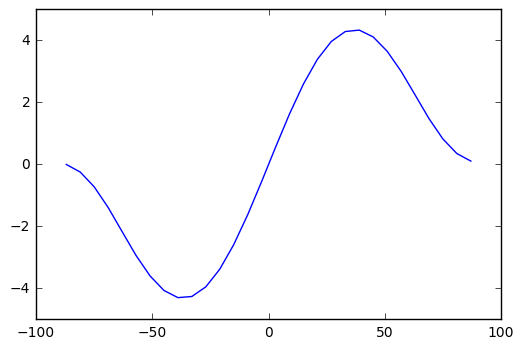

In [30]:
#  Plot the northward heat transport in this model
Rtoa = np.squeeze(diffmodel2.timeave['ASR'] - diffmodel2.timeave['OLR'])
plt.plot(diffmodel2.lat, inferred_heat_transport(Rtoa, diffmodel2.lat))